In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor
from torch import optim
from torch.utils.data import Sampler, WeightedRandomSampler
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torchsummary import summary
# import visdom
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import time
from copy import copy
from scipy.stats import mode
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils_classifier.resnet import *
from utils_classifier.darknet import *
from utils_classifier.utils_classify_DIPs import *

In [4]:
path_source = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
path_lidc = f'{path_source}lidc info/'
path_orig = f'{path_source}original/'
path_inpain = f'{path_source}inpainted inserted/'

In [5]:
batchsize = 8
torch.cuda.set_device(0)
if torch.cuda.is_available():
    device = 'cuda'

AssertionError: 
The NVIDIA driver on your system is too old (found version 9020).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.

In [ ]:
# this df is to match the Patient ID with tcia-diagnosis-data-2012-04-20 to get the Diagnosis at the Patient Level
df_meta  = pd.read_csv('lidc data/LIDC-IDRI_MetaData.csv')
df_tcia  = pd.read_csv('lidc data/tcia-diagnosis-data-2012-04-20.csv')

In [ ]:
ff = os.listdir(path_inpain)
ff = [i.split('.raw')[0] for i in ff]
ff = np.sort(ff)
ff_lidc = os.listdir(path_lidc)
ff_lidc = [i.split('.csv')[0] for i in ff_lidc]
ff_lidc = np.sort(ff_lidc)
ff = list(set(ff).intersection(set(ff_lidc)))
len(ff)

In [ ]:
a = pd.read_csv(f'{path_lidc}{ff[2]}.csv')
b = a['malignancy'].values
b

In [ ]:
def check_for_ties(values):
    tie = False
    values = np.asarray(values)
    mode0 = len(np.where(values==0)[0])
    mode1 = len(np.where(values==1)[0])
    if mode0 == mode1: 
        mode_res = -1
        tie=True
    elif mode0>mode1: 
        mode_res = 0
    else: 
        mode_res = 1
    return mode_res, tie

In [ ]:
def transform_categories_return_mode(a):
    orig = []
    mode_value = -1
    values_transformed = []
    for i in a:
        orig.append(i)
        if i <=2: values_transformed.append(0)
        if i >=4: values_transformed.append(1)
        else: continue
    if len(values_transformed)>=1:
        mode_value, _ = check_for_ties(values_transformed)
    else:
        mode_value = -1
    return mode_value

In [ ]:
# Get the list of files where malignancy can be defined (no ties)
ff_malig = []
errors_ff = []
malignancies = []
for idx, i in enumerate(ff):
    try:
        df = pd.read_csv(f'{path_lidc}{i}.csv')
    except:
        # 'EmptyDataError'
        errors_ff.append(idx)
        continue
    vals = df['malignancy'].values
    mal = transform_categories_return_mode(vals)
    if mal != -1:
        ff_malig.append(i)
        malignancies.append(mal)
df_mal = pd.DataFrame({'ids':ff_malig, 'malignancy':malignancies})
print(df_mal.shape)

In [ ]:
# match the Patient ID of df_meta with tcia-diagnosis-data-2012-04-20 to get the 
# Diagnosis at the Patient Level
df_meta  = pd.read_csv('lidc data/LIDC-IDRI_MetaData.csv')
df_meta = df_meta[['Patient Id', 'Series UID']]
df_tcia  = pd.read_csv('lidc data/tcia-diagnosis-data-2012-04-20.csv')
df_tcia = df_tcia[['TCIA Patient ID', 'Diagnosis at the Patient Level']]
print(df_meta.shape)
print(df_tcia.shape)

In [ ]:
# For each Patient ID in df_meta check if there is info in the df_tcia and merge it
df_meta_tcia = pd.merge(df_meta, df_tcia, how='left', left_on='Patient Id', right_on='TCIA Patient ID')
print(df_meta_tcia.shape)
df_meta_tcia.iloc[195:200]

In [ ]:
# In order to match df_meta_tcia and df_mal we add a column with 
# the root name of the ids of df_mal () 
df_mal['ids_name_root'] = df_mal['ids'].apply(lambda x:x.split('_')[0])
print(df_mal.shape)
df_mal.head()

In [ ]:
# match df_meta_tcia and df_mal
df_diag = pd.merge(df_meta_tcia, df_mal, how='left', left_on='Series UID', right_on='ids_name_root')
df_diag.drop(['ids_name_root', 'TCIA Patient ID'], axis=1, inplace=True)

In [ ]:
print(len(np.unique(df_diag['Patient Id'].values)))
print(pd.notna(df_diag['Diagnosis at the Patient Level']).sum())
print(pd.notna(df_diag['malignancy']).sum())
df_diag.head()

In [ ]:
# Analyze malignancy first
df_malig = df_diag.loc[pd.notna(df_diag['malignancy'])]
print(df_malig.shape)
df_malig.head()

In [ ]:
X_malig = df_malig['ids'].values
y_malig = df_malig['malignancy'].values
len(X_malig), len(y_malig)

In [ ]:
fold = 1
np.random.seed(fold)
X_train, X_val, y_train, y_val = train_test_split(X_malig, y_malig, test_size=0.2, random_state=fold)
X_train = np.sort(X_train)
X_val = np.sort(X_val)
y_train = np.sort(y_train)
y_val = np.sort(y_val)
len(X_train), len(X_val), len(y_train), len(y_val)

In [ ]:
class LIDCGAN_dataready(Dataset):
    def __init__(self, files_train_test, labels, transform = False):
        self.A = [f'{path_source}original/{i}.raw' for i in files_train_test]
        self.B = [f"{path_source}inpainted inserted/{i}.raw" for i in files_train_test]
        self.mask = [f"{path_source}mask/{i}.raw" for i in files_train_test]
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.A)
    
    def normalizePatches(self, npzarray):
        maxHU = 400.
        minHU = -1000.

        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def rotate_and_flip(self, image1, image2, image3):
        rand_int = np.random.randint(1,4)
        if np.random.rand() > .3:
            image1 = np.rot90(image1,rand_int).copy()
            image2 = np.rot90(image2,rand_int).copy()
            image3 = np.rot90(image3,rand_int).copy()
        if np.random.rand() > .5:
            image1 = np.flip(image1,0).copy()
            image2 = np.flip(image2,0).copy()
            image3 = np.flip(image3,0).copy()
        if np.random.rand() > .5:
            image1 = np.flip(image1,1).copy()
            image2 = np.flip(image2,1).copy()
            image3 = np.flip(image3,1).copy()
        return image1, image2, image3
                              
    def __getitem__(self, idx):
        imgA = np.fromfile(self.A[idx],dtype='int16').astype('float32').reshape((64,64,64))
        imgB = np.fromfile(self.B[idx],dtype='int16').astype('float32').reshape((64,64,64))
        mask = np.fromfile(self.mask[idx],dtype='int16').astype('float32').reshape((64,64,64))
        label = self.labels[idx]
        
        # v1: ONLY USE THE INSIDE OF THE CUBE (32x32x32 size)
        imgA = imgA[16:-16,16:-16,16:-16]
        imgB = imgB[16:-16,16:-16,16:-16]
        mask = mask[16:-16,16:-16,16:-16]
        
        # normalize
        imgA = self.normalizePatches(imgA)
        imgB = self.normalizePatches(imgB) 
        
        # Flips
        if self.transform:
            imgA, imgB, mask = self.rotate_and_flip(imgA, imgB, mask)
                    
        # Add channels dimension
        imgA = np.expand_dims(imgA,0)
        imgB = np.expand_dims(imgB,0)
        mask = np.expand_dims(mask,0)
        label = np.expand_dims(label,0)
        
        # Pytorch
        imgA = Tensor(imgA)
        imgB = Tensor(imgB)
        mask = Tensor(mask)
        label = Tensor(label).long()
        label = label.squeeze()
                  
        # Get name to save the data                      
#         name = self.A[idx].split('orig/')[-1]
        name = self.A[idx]
    
        return imgA, imgB, mask, name, label

In [ ]:
np.shape(X_train)

In [ ]:
sampler = class_imbalance_sampler(y_train)

In [ ]:
dataset_train = LIDCGAN_dataready(X_train, y_train, transform=False)
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, sampler = sampler)
dataset_val = LIDCGAN_dataready(X_val, y_val, transform=False)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, shuffle=False)

In [ ]:
slice_middle = 15
def plot_next_batch_dataloader(dataloader_iterX):
    a, b, mask, name, labels = next(dataloader_iterX)
    print(np.shape(a), np.shape(b), np.shape(mask), np.shape(labels))
    for i,j,k, lab in zip(a,b,mask,labels):
        lab = lab.detach().cpu().numpy()
        fig, ax = plt.subplots(1,4,figsize=(10,5))
        i = i[0].detach().cpu().numpy()
        j = j[0].detach().cpu().numpy()
        k = k[0].detach().cpu().numpy()
        print(np.shape(i), np.shape(j), np.shape(k))
        new_name = name[0].split('/')[-1][:-4]
        ax[0].imshow(i[slice_middle], vmin=0, vmax=1)
        ax[0].set_title(f'{lab}')
        ax[1].imshow(j[slice_middle], vmin=0, vmax=1)
        ax[2].imshow(np.abs(i[slice_middle]-j[slice_middle]), vmin=0, vmax=.1)
        ax[3].imshow(k[slice_middle])
        fig.tight_layout()

In [ ]:
dataloader_iter = iter(dataloader_train)
plot_next_batch_dataloader(dataloader_iter)

In [ ]:
# model = ResNet18()
layers = [2,2,2]
layers_str = str(layers)
model = Darknet3D([2,2,2],2)
model_name = f'darknet{layers_str}'
model_name = model_name.replace(', ','_').replace('[','_').strip(']')
if torch.cuda.is_available():
    model.cuda()
model.apply(weights_init);

In [ ]:
summary(model,(1,64,64,64))

In [ ]:
lr=1e-3
opt = optim.Adam(model.parameters(), lr=lr)
criterion = F.cross_entropy

In [ ]:
epochs = 2
correct_train, correct_val = 0, 0
total_train, total_val = 0, 0
loss_train_epoch, loss_val_epoch = 0, 0
y_train_all, y_val_all = [], []
pred_train_proba_all, pred_val_proba_all = [], []
best_loss_val = 100
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in tqdm_notebook(range(epochs), total = len(range(epochs)), desc=f'training fold = {fold}'):

    
    
    model.train()
    for idx, (Xa_train, Xb_train, mask_train, name_train, y_train) in enumerate(dataloader_train):
        
        start = time.time()
        pred_train_proba, loss, batch_total, batch_correct, _ = loss_batch(model, criterion, Xa_train, y_train, device)
        correct_train += batch_correct
        total_train += batch_total
        loss_train_epoch += loss.detach().cpu().numpy()
        y_train_all.extend(y_train.detach().cpu().numpy())
        pred_train_proba_all.extend(pred_train_proba)
        # Backprop
        opt.zero_grad()
        loss.backward()
        opt.step()
    accuracy_train = 100 * correct_train / total_train

    model.eval() 
    with torch.no_grad():
        for idx_val, (Xa_val, Xb_val, mask_val, name_val, y_val) in enumerate(dataloader_val):
            pred_val_proba, loss_val_batch, batch_total_val, batch_correct_val, _ = loss_batch(model, criterion, Xa_val, y_val, device)

            loss_val_epoch += loss_val_batch.detach().cpu().numpy()
            total_val += batch_total_val   
            correct_val += batch_correct_val
            pred_val_proba_all.extend(pred_val_proba)
            y_val_all.extend(y_val.detach().cpu().numpy())
        accuracy_val = 100 * correct_val/ total_val

        # Save best model according to val set
        model_saved_name = f'classifier/CNN_models/{model_name}'
        if best_loss_val > loss_val_epoch and epoch >= 2:
            best_loss_val = loss_val_epoch
            best_val_acc = accuracy_val
            pred_val_proba_best = pred_val_proba_all
            y_val_best = y_val_all    
            y_train_best = y_train_all    
            pred_train_proba_best = pred_train_proba_all
            torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict(),'optim_dict' : opt.state_dict()}, model_saved_name)
            
    train_loss.append(loss_train_epoch)
    val_loss.append(loss_val_epoch)
    train_accuracy.append(accuracy_train)
    val_accuracy.append(accuracy_val)

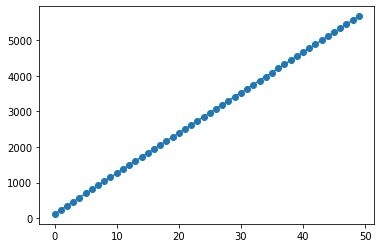

In [30]:
plt.scatter(np.arange(len(train_loss)), train_loss)
plt.plot(train_loss)

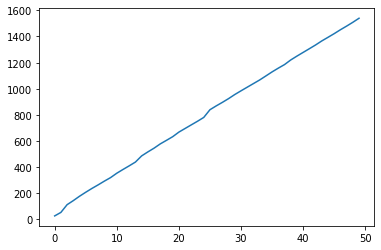

In [31]:
plt.plot(val_loss)

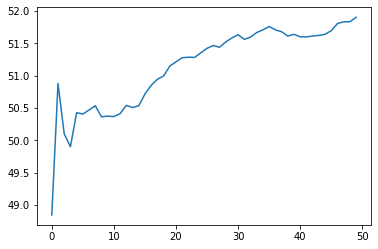

In [32]:
plt.plot(train_accuracy)

In [33]:
y_train

tensor([1, 1, 1, 0, 1, 0, 0, 0])

In [34]:
y_val

tensor([1, 1, 1, 1, 1, 1])

In [ ]:
pathxx = '/data/OMM/project results/Feb 20 19 - CycleGan clean/deep nodule prior luna v2 - cubes size 32 coefficients/images augmented/patched_subset/'
ffx = os.listdir(path)
